# City Income Distribution Analysis
This code analyzes census data on income by census tract in US Metropolitan Areas and Micro Areas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
# from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
import scipy.integrate as integrate
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib.lines as mlines
import matplotlib.ticker as mtick


# import lmfit

#import lmfit
##### This script is to analyze city-by-city income distributions

# Process raw data

In [2]:
data = pd.read_csv("CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")


# NOTE: one msa has population of 20 million which seems like way too much...
# DONE: It's NYC, which in its MSA does indeed have that many people


# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
i = 0
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

metro_ids = set()
micro_ids = set()
for _,ct in data.iterrows():
    i +=1
    msa = ct['msa']
    ct_id = ct["ct"]
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    if metro:
        metro_ids.add(msa)
    else:
        micro_ids.add(msa)



### This is just to test how many census tracts there are in different cities

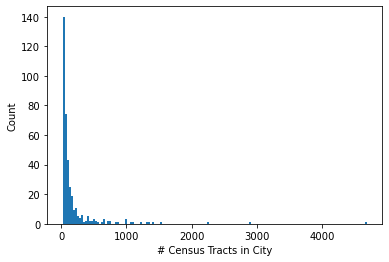

In [3]:

n_cts = {}
for _,ct in data.iterrows():
    msa = ct['msa']
    if True:#str(msa) in metro_ids:
        ct_id = ct["ct"]
        if msa not in n_cts:
            n_cts[msa] = 0
        n_cts[msa] += 1
    
n_cts_list = []
for msa in income_lists:
    if str(msa) in metro_ids:
        n_cts_list.append(n_cts[msa])
    
plt.figure()
plt.hist(n_cts_list,bins = 150)
plt.xlabel("# Census Tracts in City")
plt.ylabel("Count")
plt.show()


### This is to test on average how many how people are in a census tract

In [4]:
wps = []
for msa in pops:
    if str(msa) in metro_ids:
        wps += pops[msa]
        
# print(ps)
        
print("numer of workers:",np.mean(np.array(wps)))


ps = []
for msa in fullpops:
    if str(msa) in metro_ids:
        ps += fullpops[msa]
        
# print(ps)
        
print("numer of total people:",np.mean(np.array(ps)))


numer of workers: 2335.1214325433207
numer of total people: 4491.246336734847


In [5]:
mean = np.mean(n_cts_list)
print(mean)

176.49602122015915


# Analyze Distributions

## Fig 2 - Kernal density dist. for selected cities

No handles with labels found to put in legend.


Text(0, 0.5, 'PDF')

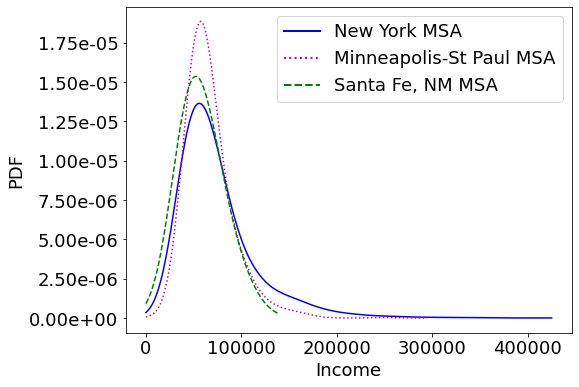

In [6]:
plt.rc('xtick', labelsize=18)     
plt.rc('ytick', labelsize=18)

plt.rcParams.update({'font.size': 18})

kde_distr = {}
kde_distr_small = {}
kde_pdfs = {}
x_inc_all = []
y_pop_all = []
kde = {}
# city_pop

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale


def draw_kde_one_city(msa, marker):
    # copied everything in for loop 
    # msa = CBSA Code for metro area
    
    
    metro = str(msa) in metro_ids
    msaname = idmappings["CBSA Title"][str(msa)]
    if not isinstance(msaname,str):
        msaname = list(msaname)[0]
        
    income_list = income_lists[msa]

    cpop = city_pops[msa]
    
    x = np.linspace(0,1.2*max(income_list),500)
    
    income_list = np.array(income_list)
    pop = np.array(fullpops[msa])/sum(fullpops[msa])

    kernel = scipy.stats.gaussian_kde(income_list, weights=pop, bw_method= wide_silverman)
    kde[msa] = kernel
    sumprob = scipy.integrate.quad(kernel.pdf,0,1.2*max(income_list))
    
    datx, daty = x, kernel.pdf(x)
    ax.plot(datx, daty, marker)

 
      
    n_samples = round(n_cts[msa]**.75/6)
    if n_samples < 15:
        n_samples = 15
    small_sample = np.linspace(0,1.2*max(income_list),n_samples)
    kde_distr[msa] = (datx, daty)
    kde_distr_small[msa] = (small_sample, kernel.pdf(small_sample))
    kde_pdfs[msa] = kernel.pdf
    

    return msaname, cpop

fig = plt.figure(figsize = (8, 6))    
ax = fig.add_subplot(111)
# draw 3 cities. NY, Santa Fe, Miniapolous 


# new york
msaname1, cop1 = draw_kde_one_city(35620, "b-")

# minneapolis 
msaname2, cop2 = draw_kde_one_city(33460, "m:")

# santa fe
msaname3, cop3 = draw_kde_one_city(42140, "g--")
plt.legend()

# legend cheats
blueline = mlines.Line2D([], [],color='b', marker="None", linestyle='-',linewidth=2, label= "New York MSA" )
magdots = mlines.Line2D([], [],color='m', marker="None", linestyle=':',linewidth=2, label= "Minneapolis-St Paul MSA" )
greendash = mlines.Line2D([], [],color='g', marker="None", linestyle='--',linewidth=2, label= "Santa Fe, NM MSA" )

plt.legend(handles = [blueline, magdots, greendash ])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.xlabel("Income")
plt.ylabel("PDF")




In [46]:
msaname1

'New York-Newark-Jersey City, NY-NJ-PA'

In [47]:
msaname2

'Minneapolis-St. Paul-Bloomington, MN-WI'

In [48]:
msaname3

'Santa Fe, NM'

AttributeError: 'Rectangle' object has no property 'normed'

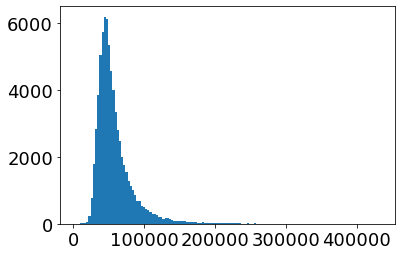

In [7]:
# COMPARING DISTRIBUTIONS TO MAXWELL-BOLTZMANN & PARETO DISTRIBUTIONS (for background of paper):

m_id = 16980 # Chicago
i_list = [item for sublist in income_lists.values() for item in sublist]# income_lists.values)


ydat,xdat,_ = plt.hist(i_list, bins=140, normed=True)
xdat = np.array(xdat[:-1]) + 0.5*(xdat[-1]-xdat[-2]) 
x = np.linspace(0, max(i_list), 100)


def maxwell(x,scale,loc):
#     print("in maxwell")
    return np.sqrt(2/np.pi)*((x - loc) / scale)**2*np.exp((-((x - loc) / scale)**2)/2)/(scale**1)
# def maxwell(x,a,scale,scale2,loc):
# #     print("in maxwell")
#     return scale2*np.sqrt(2/np.pi)*((x - loc) / scale)**2*np.exp((-((x - loc) / scale)**2)/(2*a**2))/((a**3)*scale)

# def maxwell(x,loc,scale):
#     return scipy.stats.maxwell.pdf(x,loc=loc,scale=scale)

x_maxwell_0 = np.array([i for i in xdat if i < 75000.])#*10**(-4)
y_maxwell_0 = np.array(ydat[:len(x_maxwell_0)])#*10**7
x_maxwell = np.array([i for i in x_maxwell_0 if i > 15000.])#*10**(-4)
y_maxwell = np.array(y_maxwell_0[(len(y_maxwell_0)-len(x_maxwell)):])#*10**7
# print(len(x_maxwell),len(y_maxwell))
# print(x_maxwell,y_maxwell)
# plt.plot(x_maxwell,y_maxwell,label="from bins")
popt_m, pcov = curve_fit(maxwell, x_maxwell, y_maxwell,p0=[23188.79033513, 28843.553447])
print(popt_m)
# testx = np.linspace(np.min(x_maxwell),np.max(x_maxwell),50)

# def residual(params, x, true_data):
# #     model = maxwell(x,params['a'],params['scale'],params['scale2'],params['loc'])
#     model = maxwell(x,params['scale'],params['loc'])
#     return true_data-model
        
# mParams = lmfit.Parameters()
# mParams.add_many(('scale',37000.,True,0.,200000.),('loc',0.,True,0.))
# mModel = lmfit.Model(maxwell)
# mFits   = lmfit.minimize(residual, mParams, args=(x_maxwell, y_maxwell))
# mParams = mFits.params
# print(mParams)
# res = mModel.eval(params=mParams,x=x_maxwell)


# params = scipy.stats.maxwell.fit(i_list, floc=0)
# plt.plot(x_maxwell,scipy.stats.maxwell.pdf(x_maxwell,loc=params[0],scale=params[1]))
# print(params)
    
# plt.plot(x_maxwell, res, lw=3, label="Maxwell-B/oltzmann lmfit")
plt.plot(x_maxwell, maxwell(x_maxwell, *popt_m),"--", lw=3, label="Maxwell-Boltzmann")



def pareto(x,b,scale):
    return scale*b/(x**(b+1))

x_par = [i for i in xdat if i >= 75000]
y_par = ydat[(len(ydat)-len(x_par)):]
popt_p, pcov = curve_fit(pareto, x_par, y_par,)

plt.plot(x_par, pareto(x_par, *popt_p),"--", lw=3, label="Pareto")
plt.xlabel("Income")
plt.ylabel("Probability")
plt.xlim(right=200000)
plt.legend()

    ## calculate moments using pdfs generated by kde for each city
Uses scipy.stats.rv_continuous.moment
NOTE: Moments change significantly from raw data to kde-generated pdf. We assume that these changes are representative of the true distributions


    FIXME: Some moments are being returned as zero

## Run the KDE code to generate kde's for all msa's

In [8]:
for msa in income_lists:
    metro = str(msa) in metro_ids
    msaname = idmappings["CBSA Title"][str(msa)]
    if not isinstance(msaname,str):
        msaname = list(msaname)[0]

    
    income_list = income_lists[msa]
  
    cpop = city_pops[msa]
    
    x = np.linspace(0,1.2*max(income_list),100)
    
    income_list = np.array(income_list)
    pop = np.array(fullpops[msa])/sum(fullpops[msa])
     
    kernel = scipy.stats.gaussian_kde(income_list, weights=pop, bw_method= wide_silverman)
    kde[msa] = kernel
    
    
    sumprob = scipy.integrate.quad(kernel.pdf,0,1.2*max(income_list))
    
    datx, daty = x, kernel.pdf(x)
   
    n_samples = round(n_cts[msa]**.75/6)
    if n_samples < 15:
        n_samples = 15
    small_sample = np.linspace(0,1.2*max(income_list),n_samples)
    kde_distr[msa] = (datx, daty)
    kde_distr_small[msa] = (small_sample, kernel.pdf(small_sample))
    kde_pdfs[msa] = kernel.pdf

In [9]:

class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf,x = ",x,"msa=",msa)
        #print("in pdf",x)
        ret = kde_pdfs[msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)

# maps moment number n to list of those moments
moments = {}
cpops = []
errors = []

def calc_moment(dist,m_n):
    avg = np.mean(dist)
    if m_n==1:
        return avg
    n = len(dist)
    diff = dist - avg
    diff_mn = diff**m_n
    m = (1./n)*np.sum(diff_mn)
    return m
def calc_moment_kde(msa,m_n):
    mx = max(income_lists[msa])
    integral = scipy.integrate.quad(lambda x: x*kde_pdfs[msa](x),0,1000000)
    if integral[1]/(integral[0]) > 0.01:
        print("WARNING! Large error in integration")
        set_trace()
    avg = integral[0]
    if m_n==1:
#         print("avg:",avg)
        return avg
    f = lambda x: (x-avg)**m_n*kde_pdfs[msa](x)
    m = scipy.integrate.quad(f,0,1000000)[0]
    if abs(m) < 1.:
        errors.append(msa)
        set_trace()
    if m_n ==1:
        print("avg:",avg)
        print("m:",m)
    return m
    
# errors = [10780,11940,12860,16020]
for msa in kde_pdfs: 

    for n in range(1,5):

        if n not in moments:
            moments[n] = []
        m_kde = distribution.moment(n,msa)
        m_raw = scipy.stats.moment(income_lists[msa],moment=n)
        manual_m = calc_moment(income_lists[msa],n)
        manual_m_kde = calc_moment_kde(msa,n)
        

    
        moments[n].append(manual_m_kde)
    cpops.append(city_pops[msa])


/Users/elisaheinrichmora/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1707: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ0, _a, _b,
/Users/elisaheinrichmora/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1707: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ0, _a, _b,


49780 4
Zanesville, OH
mkde, m_raw =  4.971766655924369e+18 4261408190322505.5


(array([3., 1., 2., 4., 6., 3., 3., 3., 2., 2.]),
 array([31117. , 33501.1, 35885.2, 38269.3, 40653.4, 43037.5, 45421.6,
        47805.7, 50189.8, 52573.9, 54958. ]),
 <BarContainer object of 10 artists>)

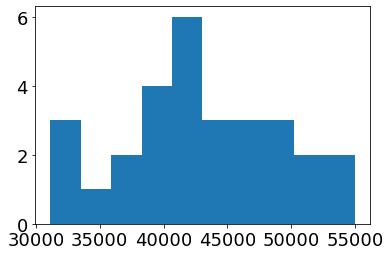

In [10]:
print(msa,n)
print(idmappings["CBSA Title"][str(msa)])

m_kde = distribution.moment(n,msa)
m_raw = scipy.stats.moment(income_lists[msa],moment=n)
print("mkde, m_raw = ",m_kde,m_raw)
plt.hist(income_lists[msa])
# array([ 6., 13.,  7., 16., 10.,  7.,  3.,  2.,  1.,  2.]), array([26744. , 31915.4, 37086.8, 42258.2, 47429.6, 52601. , 57772.4,
#        62943.8, 68115.2, 73286.6, 78458. ])

### Analyze distribution moments vs. city size

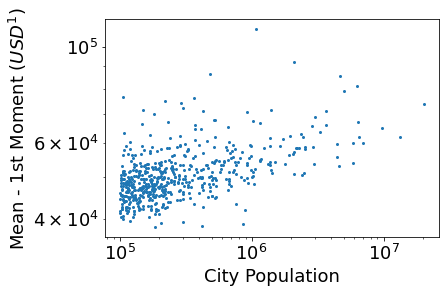

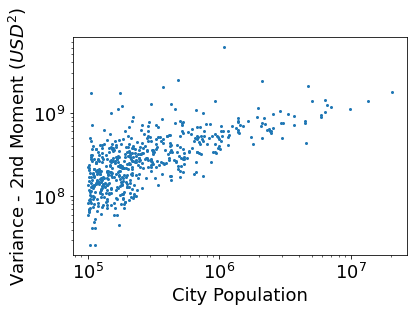

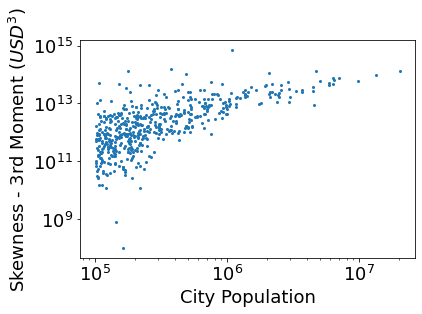

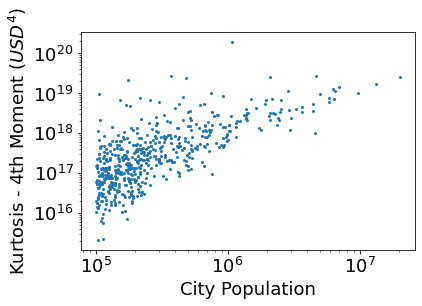

In [11]:
# moment_p = moments
# cpops_p = cpops
import copy

scale_y = {
    1:1.,
    2:.075,
    3:.01,
    4:.01,
    5:.15
}

scale_y = {
    1:1.,
    2:.02*10**-8,
    3:.01,
    4:.01,
    5:.15
}

cpops_map = {}
moments_cp = {}
for n in [1,2,3,4]:
    cpops_map[n] = copy.copy(cpops)
    moments_cp[n] = copy.copy(moments[n])
    

# for n in [2,3,4]:
#     cpops_map[n] = np.array(cpops_map[n])
#     moments_cp[n] = np.array(moments_cp[n])
#     amax = np.argmax(moments_cp[n])
#     cpops_map[n] = np.delete(cpops_map[n],amax)
#     moments_cp[n] = np.delete(moments_cp[n],amax)
#     if n==4:
#         for _ in range(4):
#             amax = np.argmax(moments[n])
#             cpops_map[n] = np.delete(cpops_map[n],amax)
#             moments[n] = np.delete(moments[n],amax)
    
    
for n in range(1,5):
    plt.figure()
    plt.xlabel("City Population")
    lbl = "nth moment, n = " + str(n) 
    if n == 2:
        lbl = r"Variance - 2nd Moment ($USD^2$)"        
    elif n == 1:
        lbl = r"Mean - 1st Moment ($USD^1$)"
    elif n == 3:
        lbl = r"Skewness - 3rd Moment ($USD^3$)"
    elif n == 4:
        lbl = r"Kurtosis - 4th Moment ($USD^4$)"
    plt.ylabel(lbl)
    # TODO: fit regressions in log-linear space, calculate R^2 & p-value
    plt.plot(cpops_map[n], moments_cp[n],'o',markersize=2)
#     bottom,top = plt.ylim()
    plt.yscale("log")
#     plt.ylim((10**(4*n),top))
#     plt.ylim((0,scale_y[n]*top))
    plt.xscale("log")
    plt.show()
    plt.close()
#plt.hist(samples)


### Correlation & Power Law

Mean - 1st Moment
Covariance: 
[[2.00024368e+12 4.43994606e+09]
 [4.43994606e+09 6.09466110e+07]]
Poly-fit
[9.87575433 0.07603054]


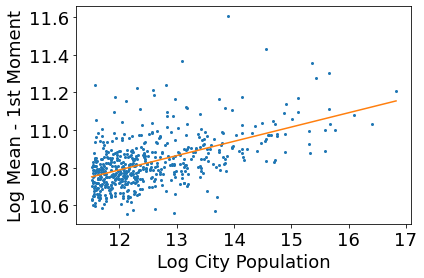


Pearsons correlation: 0.402
P-value: 0.000
Spearmans correlation: 0.502
P-value: 0.000
__________________________________


NameError: name 'sm' is not defined

In [12]:
import numpy as np
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy.polynomial.polynomial as poly


slope = []
slope_u = []
slope_l = []

for n in range(1,5):
    
    lbl = "nth moment, n = " + str(n) 
    if n == 2:
        lbl = r"Variance - 2nd Moment"        
    elif n == 1:
        lbl = r"Mean - 1st Moment"
    elif n == 3:
        lbl = r"Skewness - 3rd Moment"
    elif n == 4:
        lbl = r"Kurtosis - 4th Moment"
        
    print(lbl)
    
    print("Covariance: ")
    print(np.cov(cpops_map[n], moments_cp[n]))
    print("Poly-fit")
    log_moments = []
    log_populations = []
    for i in range(len(moments_cp[n])): 
        if np.isfinite(np.log(moments_cp[n][i])):
            if np.isfinite(np.log(cpops_map[n][i])):
                log_moments.append(np.log(moments_cp[n][i]))
                log_populations.append(np.log(cpops_map[n][i]))
    
    coeff = poly.polyfit(log_populations, log_moments, 1)
    print(coeff)
    x = log_populations
    new_x = np.linspace(np.min(x), np.max(x))
    new_y = poly.polyval(new_x, coeff)
    
    plt.xlabel("Log City Population")
    plt.ylabel('Log '+ lbl)
    plt.plot(log_populations, log_moments, 'o', new_x, new_y, markersize=2)
    plt.show()
    
    print("")
    
    corr, pval = pearsonr(cpops_map[n], moments_cp[n])
    print('Pearsons correlation: %.3f' % corr)
    print('P-value: %.3f' % pval)

    cor, pval1 = spearmanr(cpops_map[n], moments_cp[n])
    print('Spearmans correlation: %.3f' % cor)
    print('P-value: %.3f' % pval1)
    print("__________________________________")
    
    # add ols to get confidence interval for parameters 
    X = log_populations
    y = log_moments
    
    X = sm.add_constant(X)
    
    res = sm.OLS(y,X ,missing = 'drop').fit()
                
    CI = 0.05 # 1 - confidence interval 
     # exponent
    slope.append(res.params[1])
    slope_l.append(res.conf_int(CI) [0][1]) # confidence interval, lower bound
    slope_u.append(res.conf_int(CI) [1][1]) #confidence interval, upper bound
    
    print("slope = {:.2f}, [{:.2f},{:.2f} ]".format(slope, slope_l, slope_u))
    
#  cpops_map[n], moments_cp[n]

### KL divergence

Run test comparing every MSA to one typical large city and plot the metric against city size. 

In [ ]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set()
from scipy.stats import ks_2samp
from scipy.stats import entropy 
from scipy.special import kl_div, rel_entr 
import scipy as sp


In [ ]:
# def kl_divergence(p, q):
#     '''
#     Epsilon is used here to avoid conditional code for
#     checking that neither P nor Q is equal to 0.
#     '''

#     eps = 0.00001
#     p += eps
#     q += eps
    
#     divergence = np.sum(p* np.log(p/q))
#     return divergence
    
def kl_divergence(a, b):
    epsilon = 0.00001
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    a = a+epsilon
    b = b+epsilon
    
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))




In [ ]:
kde_distr = {}
kde_distr_small = {}
kde_pdfs = {}
x_inc_all = []
y_pop_all = []
kde = {}



def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale

def max_value(inputlist):
    maxs= []
    for sublist in inputlist:
        maxs.append(np.max(sublist))
        
    return np.max(maxs)

def get_key(val): 
    for key, value in city_pops.items(): 
         if val == value: 
            return key 
max_max= max_value(list(income_lists.values()))        
msa_big_city = get_key(np.max(list(city_pops.values())))



income_list_big_city = income_lists[msa_big_city]
cpop_big_city = city_pops[msa_big_city]

income_list_big_city = np.array(income_list_big_city)
income_list_big_city_norm = np.array(income_list_big_city)/ np.max(income_list_big_city)
pop_big_city = np.array(fullpops[msa_big_city])/sum(fullpops[msa_big_city])
    
kernel_big_city = scipy.stats.gaussian_kde(income_list_big_city, weights=pop_big_city)#, bw_method= wide_silverman)
kde[msa_big_city] = kernel_big_city 




x = np.linspace(0, 1.2* max(max_max, 100))
pdf_kde_bc= kernel_big_city.pdf(x)/sp.integrate.simps(kernel_big_city.pdf(x), x)

datx_bc, daty_bc = x, pdf_kde_bc

kl_values = []
ks_values = []

for msa in income_lists:
    
    income_list = income_lists[msa]
    cpop = city_pops[msa]

    
    income_list = np.array(income_list)
    income_list_norm = np.array(income_list)/ np.max(income_list)
    
    pop = np.array(fullpops[msa])/sum(fullpops[msa])

    
    kernel = scipy.stats.gaussian_kde(income_list, weights=pop)
    kde[msa] = kernel

    pdf_kde= kernel.pdf(x)/sp.integrate.simps(kernel.pdf(x), x)

    
#     x = np.linspace(0,1.2*max(income_list),100)
    
    datx, daty = x, pdf_kde

    
    
    kl_values.append(kl_divergence(daty_bc, daty))
    
    val = list(ks_2samp(income_list_big_city_norm, income_list_norm))
    ks_values.append(val[0])


In [ ]:
plt.figure()
plt.plot(list(city_pops.values()), kl_values, 'o', markersize=2)
plt.xlabel("City Population")
plt.ylabel('KL-value')

plt.xscale("log")
plt.show()

corr, pval = pearsonr(list(city_pops.values()), kl_values)
print('Pearsons correlation: %.3f' % corr)
print('P-value: %.3f' % pval)

cor, pval1 = spearmanr(list(city_pops.values()), kl_values)
print('Spearmans correlation: %.3f' % cor)
print('P-value: %.3f' % pval1)

### KS test
Run test comparing every MSA to one typical large city and plot the metric against city size. 

In [ ]:
plt.figure()
plt.plot(list(city_pops.values()), ks_values, 'o', markersize=2)
plt.xlabel("City Population")
plt.ylabel('KS-value')

plt.xscale("log")
plt.show()

corr, pval = pearsonr(list(city_pops.values()), ks_values)
print('Pearsons correlation: %.3f' % corr)
print('P-value: %.3f' % pval)

cor, pval1 = spearmanr(list(city_pops.values()), ks_values)
print('Spearmans correlation: %.3f' % cor)
print('P-value: %.3f' % pval1)

## Compare shapes of distributions by rescaling to normalize peak point

In [ ]:
# find mean peak point, toward which to renormalize

max_xs = []
max_ys = []
x_lim = 0
y_lim_b,y_lim_t = 1.,0.
for msa in kde_distr:
    x,y = kde_distr[msa]
    x = np.array(x)
    y = np.array(y)
    max_x,max_y = x[np.argmax(y)],np.max(y)
    max_xs.append(max_x)
    max_ys.append(max_y)
    x_bound = np.max(x)
    if x_bound>x_lim:
        x_lim = x_bound
    y_bound_b = np.min(y)
    if y_bound_b<y_lim_b:
        y_lim_b = y_bound_b
    y_bound_t = np.max(y)
    if y_bound_t>y_lim_t:
        y_lim_t = y_bound_t    
    
    
mean_max_x = np.mean(np.array(max_xs))
mean_max_y = np.mean(np.array(max_ys))


scaled_distr = {}

sorted_cpops = {k: v for k, v in sorted(city_pops.items(), key=lambda item: item[1])}
# for msa in sorted_cpops:
#     x,y = kde_distr[msa]
#     x = np.array(x)
#     y = np.array(y)
#     max_x,max_y = x[np.argmax(y)],np.max(y)
#     newx,newy = x*(mean_max_x/max_x),y*(mean_max_y/max_y)
#     scaled_distr[msa] = newx,newy
#     pop = city_pops[msa]
#     lbl = "pop: "+str(pop)
#     plt.figure()
#     plt.plot(newx,newy,label=lbl)
#     plt.xlim(right=x_lim)
#     plt.legend()
#     plt.show()
#     plt.close()

    
sorted_cpops_arr = np.array(list(sorted_cpops.keys()))
n_cities = len(list(sorted_cpops.keys()))

fig = plt.figure()
def animate(i):
    #label = label + ': G=' + str(round(gini(population), 2))
    plt.cla()
    msa = sorted_cpops_arr[i]
    x,y = kde_distr[msa]
    x = np.array(x)
    y = np.array(y)
    max_x,max_y = x[np.argmax(y)],np.max(y)
    newx,newy = x*(mean_max_x/max_x),y*(mean_max_y/max_y)
    scaled_distr[msa] = newx,newy
    pop = city_pops[msa]
    lbl = "pop: "+str(pop)
    plt.plot(newx,newy,label=lbl)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(right=x_lim)
    plt.ylim(bottom=y_lim_b,top=y_lim_t)
    plt.legend()
    plt.grid(True)

anim = FuncAnimation(fig, animate, #init_func=init,
                               frames=n_cities)#), interval=20)#, blit=True)
                               #frames=int(n_cities/100))#), interval=20)#, blit=True)

HTML(anim.to_jshtml())
    

In [ ]:
for msa in income_lists:
    inc = income_lists[msa]
    x = np.linspace(min(inc),max(inc),50)
    fit_alpha, fit_loc, fit_beta=scipy.stats.gamma.fit(inc)
    print(fit_alpha,fit_loc,fit_beta)
    plt.figure()
    pdf = scipy.stats.gamma(fit_alpha,fit_loc,fit_beta).pdf
    plt.plot(x,pdf(x),'-')
    plt.show()
    plt.close()

In [ ]:
from mpl_toolkits import mplot3d

prob_all = []
income_all = []
city_pop_all = []



i=0
j = 1
for msa in kde_distr:
    j += 1
    #print(j)
    # skip over anything not a MSA
    if str(msa) in micro_ids:
        continue
    i += 1
    #print(i)
    print(i/384.)
    incomes,prob = kde_distr[msa]
    incomes = incomes#[:-1]
    #normed_np = [float(i)/sum(num_people) for i in num_people]
    #num_people = normed_np
    #num_people_cleaned = []
    city_pop = city_pops[msa]
    #skip over smaller cities with sparse data
#     if city_pop < 0.25*10**7:
#         continue
    for (prob,inc) in zip(prob,incomes):
        if not prob == 0:# and ctinc < 150000:
            prob_all.append(ctpop)
            income_all.append(ctinc)
            city_pop_all.append(np.log(city_pop))
print("finished")

fig2 = plt.figure()
#ax = plt.axes(projection='3d')

ax2 = fig2.gca(projection='3d')
#city_pop_all.reverse()
# X, Y = np.meshgrid(city_pop_all, income_all)
# Z = ?
# ax2.plot_wireframe(X,Y,num_people_all)#,cmap='viridis',linewidth=0.2, antialiased=True)
ax2.plot_trisurf(city_pop_all,income_all, prob_all,cmap='viridis',linewidth=0.2, antialiased=True)





ax2.set_xlabel('log(City Population)')
ax2.set_ylabel('Income')
ax2.set_zlabel('# people')
ax2.set_title("income distributions across city size")
ax2.view_init(30,10)
#TODO: Plot fits from A) null model of two independent scaling variables B) test model where two dependent variables are correlated
plt.show()

#TODO: Better visualization: Polygon add_collection

# Reproduce Decile Scaling result

In [ ]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

for msa in income_lists:
    if str(msa) in metro_ids:
        income_list = income_lists[msa]
        pop_list = fullpops[msa]
        city_pop = city_pops[msa]

        #split into deciles
        sum_pop = sum(pop_list)
        pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
        cumulative_pop = 0.
        current_decile = 1
        # summed population and income for current decile
        decile_pop = 0.
        decile_inc = 0.
        # sort by income
        income_list,pop_list = (list(t) for t in zip(*sorted(zip(income_list, pop_list))))
        for ctpop, ctinc in zip(pop_list,income_list):
            cumulative_pop += ctpop
            decile_pop += ctpop
            decile_inc += ctinc*ctpop
            if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
    #             if cumulative_pop == pop_cutoffs[9]:
    #                 print("finish reached")
                current_decile += 1
                #store in deciles
                correction = (sum_pop/10.)/(decile_pop)
                decile_inc *= correction 
                #normalize to per person metric (equivalent to diving by N in scaling equation)
#                 decile_inc *= 1./sum_pop
                #print(correction)
#                 print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)
                
                deciles[(current_decile-1)][0].append(decile_inc)
                deciles[(current_decile-1)][1].append(city_pop)
                #reset
                decile_pop = 0
                decile_inc = 0

#         sum_inc = np.sum(np.array(income_list)*np.array(pop))

        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)



plt.rcParams.update({'font.size': 14})

    
plt.figure()
ax = plt.gca()
decileFits = {}
decileModels = {}
decileParams = {}
for i in range(1,11):
    x= list(deciles[i][1])
    y = list(deciles[i][0])
#     print("decile:",i,"x,y = ",x,y)
    plt.scatter(x,y,s=2)
    decileParams[i] = lmfit.Parameters()
    decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))
    

    decileModels[i] = lmfit.Model(standardModelFunc)
    decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
    decileParams[i] = decileFits[i].params
    
    #using curve_fit
    logx = np.log(x)
    logy = np.log(y)
    coeff, var = curve_fit(standardLogMod, logx, logy)
    
#     lbl = "decile "+str(i)+", $\\Beta = $"+str(round((1.+coeff[1]),3))#+"$"
    lbl = "decile {}; $\\beta$ = {}".format(str(i),str(round((1.+coeff[1]),3)))
#     lbl = r'$test {}$'.format(coeff[1])
    print(coeff)
    fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
    #print(x,fity)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.plot(x, fity,'-',label=lbl,markersize=1)
    plt.xlabel("City Population")
    plt.ylabel("Summed Decile Income (USD)")
#     plt.ylabel("Decile-Averaged Per-Person Income (USD)")
    #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)
    


handles, labels = ax.get_legend_handles_labels()
# ax.legend()
plt.gca().legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1, 0.5))

# plt.legend()


# TODO: Redo with kde distributions


    
#plt.plot(np.log(deciles[1][1]),np.log([deciles[1][0]]))

# Reproduce Decile Scaling result using kde distributions

In [ ]:

class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf,x = ",x,"msa=",msa)
        try:
            ret = kde_pdfs[msa](x)
        except TypeError:
            ret = kde_pdfs[msa[0]](x)
        #print("ret=",ret)
        return ret



# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

for msa in income_lists:
    distribution = custom_distribution(momtype=0,a=0,b=3.*max(income_lists[msa]))
    if str(msa) in metro_ids:
        
        city_pop = city_pops[msa]
        decile_pop = city_pop/10.
        lb = 0
        for i in range(1,11):
#             print(i) 
            
            ub = distribution.ppf(.1*i,msa)
            #print(end_h)
            pdf = kde_pdfs[msa]
            decile_inc = 10.*distribution.expect(lambda x: x,args=([msa]),lb=lb,ub=ub)*decile_pop
            if np.isnan(decile_inc) or decile_inc == 0 or decile_inc == 0.:
                print(msa,i,decile_inc)
                print(lb,ub)
#             print("mean_inc",decile_inc)
#             print("lb=",lb,"ub=",ub)
            
            
            lb = ub
            
            deciles[i][0].append(decile_inc)
            deciles[i][1].append(city_pop)
        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)


plt.rcParams.update({'font.size': 14})
    
plt.figure()
ax = plt.gca()
decileFits = {}
decileModels = {}
decileParams = {}
for i in range(1,11):
    x= list(deciles[i][1])
    y = list(deciles[i][0])
    #print("decile:",i,"x,y = ",x,y)
    plt.scatter(x,y,s=2)
    decileParams[i] = lmfit.Parameters()
    decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))
    

    decileModels[i] = lmfit.Model(standardModelFunc)
    decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
    decileParams[i] = decileFits[i].params
    
    #using curve_fit
    logx = np.log(x)
    logy = np.log(y)
    coeff, var = curve_fit(standardLogMod, logx, logy)
    
    lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
    print(coeff)
    fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
    #print(x,fity)
    ax.plot(x, fity,'--',label=lbl,markersize=1)
    plt.xlabel("City Population")
    plt.ylabel("")
    #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)
    

ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()


# TODO: Redo with kde distributions


    
#plt.plot(np.log(deciles[1][1]),np.log([deciles[1][0]]))